# Correlation figure for twins activation maps

- grab activation maps
- Load pedigree
- stack in 3 dictionary :
    - MZ twins: Twin1, Twin2
    - DZ twins: Twin1, Twin2
    - Unrelated subject: S1, S2


In [29]:
import os
import glob
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec as gs
import nibabel as nib
import numpy as np
import pandas as pd
import multiprocessing 
import collections
import patsy as pat
from sklearn import linear_model as sln

In [30]:
%matplotlib inline

In [31]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [32]:
# Deal with minc being all weird
def roll_all(arr):
    tmp = arr
    for i in np.arange(len(arr.shape)):
        tmp = np.rollaxis(tmp, -1, i)
    return tmp

In [33]:
# Set path
path_root = '/media/yassine/data_disk/Drive/HCP2/'
path_root_spm = '/media/yassine/data_disk/data/HCP/SPM/'
path_spm = os.path.join(path_root_spm,'/media/yassine/data_disk/data/HCP/SPM/hcp_language_story_activation_maps_22-Feb-2017')

In [51]:
# Set task , trial and sbt
task_name = path_spm.split('/')[-1].split('_')[1]
list_trial = os.listdir(os.path.join(path_spm,'group_maps'))
list_trial= [ll.split('.')[0] for ll in list_trial]

In [52]:
task_name

'language'

In [35]:
#list_trial=list_trial[::-1]
list_trial

['story']

In [36]:
dict_trial = {ind:trial for ind,trial in enumerate(list_trial)}

In [37]:
# get pheno file
pheno_file = os.path.join(path_root,"subtypes_scores/26-10-2016/pheno/hcp_pheno_{}_raw.csv".format(task_mame))
pedig_df = pd.read_csv(pheno_file).filter(regex = r'(ID|Subject|Zygosity|Twin_Stat|Gender)').rename(columns={'Subject':'ID'})

In [38]:
pedig_df.head()

,ID,Gender,Twin_Stat,Zygosity,Mother_ID
0,HCP100206,1.0,NotTwin,NotTwin,56037.0
1,HCP100307,2.0,Twin,NotMZ,51488.0
2,HCP100408,1.0,Twin,MZ,51730.0
3,HCP100610,1.0,Twin,NotMZ,52813.0
4,HCP101006,2.0,Twin,MZ,51283.0


In [39]:
pedig_raw = pd.read_csv(pheno_file).rename(columns={'Subject':'ID'})
mask_i = nib.load(os.path.join(path_root_spm,'func_mask_group_stereonl.nii.gz'))
mask = mask_i.get_data().astype(bool)

In [40]:
# Regress noise and save residual stack
n_sub = pedig_raw.shape[0]
n_vox = np.sum(mask)
n_seed = len(dict_trial.keys())
dict_resid = dict()

for sid in dict_trial.keys():
    ID_stack = list()
    if '_vs_'in dict_trial[sid]:
        trial = 'contrast_' + dict_trial[sid]
    else:
        trial = dict_trial[sid]
        
    # Build the regression model for the spm maps
    mod = sln.LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
    sub_spm = np.zeros((n_sub, n_vox))
    for rid, row in pedig_raw.iterrows():
        p = glob.glob(os.path.join(path_spm,'spm_maps',row['ID'],'all_runs','spm_{}.*'.format(trial)))
        if p:
            p=p[0]
            tmp_ = nib.load(p).get_data()
            if p.split('.')[-2] == 'mnc':
                tmp_ = roll_all(tmp_)
            d = tmp_[mask]
            sub_spm[rid, :] = d
            #ID_stack[rid,0] = row['ID']
            ID_stack.append(row['ID'])
        else:
            sub_spm[rid, :] = 'NaN'
            ID_stack.append('NaN')
            
    # remove NaN's from stacks and subject IDs
    ID_= [x for x in ID_stack if str(x) != 'NaN']
    sub_=[row for row in sub_spm if not np.isnan(row).any()]
    
    # build model
    data = pedig_raw[pedig_raw['ID'].isin(ID_)]
    dmatrix = pat.dmatrix('FD_scrubbed_mean + BPSystolic + BPDiastolic + BMI', data=data)
    
    # get residual
    res = mod.fit(dmatrix, sub_)
    resid = sub_ - res.predict(dmatrix)
    
    # clean pheno tables according to existing IDs then make MZ,DZ,Sib,Unr cathegories
    pedig_ = pedig_df.loc[pedig_df['ID'].isin(ID_)]
    
    # MZ table 
    MZ_df = pedig_.loc[pedig_['Zygosity'] == 'MZ']
    mask_mz = [True if np.sum(MZ_df.Mother_ID == row.Mother_ID) == 2 else False for ind, row in MZ_df.iterrows()]
    MZ_df_clean = MZ_df[mask_mz]
    
    # DZ table
    DZ_df = pedig_.loc[pedig_['Zygosity'] == 'NotMZ']
    mask_dz = [True if np.sum(DZ_df.Mother_ID == row.Mother_ID) == 2 else False for ind, row in DZ_df.iterrows()]
    DZ_df_clean = DZ_df[mask_dz]
    DZ_df_clean.count()
    
    # Sib table
    Sib_df = pedig_.loc[pedig_['Zygosity'] == 'NotTwin']
    mask_sib = [True if np.sum(Sib_df.Mother_ID == row.Mother_ID ) == 2 else False for ind, row in Sib_df.iterrows()]
    Sib_df_clean = Sib_df[mask_sib]
    Sib_df_clean.count()
    
    # Unr table
    UnR_df = pedig_.loc[pedig_['Zygosity'] == 'NotTwin']
    mask_UnR = [True if np.sum(UnR_df.Mother_ID == row.Mother_ID) == 1 else False for ind, row in UnR_df.iterrows()]
    UnR_df_clean = UnR_df[mask_UnR]
    UnR_df_clean.count()
    
    #create a fake pair of mother id for unrelated person
    samp_ = random.sample(range(1, 1000), int(len(UnR_df_clean)/2))
    samp = samp_+samp_
    UnR_df_clean.loc[:,'Mother_ID']=samp
    UnR_df_clean.loc[:,'Zygosity']=['UnR']* int(len(UnR_df_clean))
    
    # store stack, pheno and residual dictionary
    dict_ = {'stack_{}'.format(trial):sub_ ,
             'resid_{}'.format(trial):resid ,
             'ID_{}'.format(trial):ID_,
             'MZ_df_{}'.format(trial):MZ_df_clean,
             'DZ_df_{}'.format(trial):DZ_df_clean,
             'Sib_df_{}'.format(trial):Sib_df_clean,
             'UnR_df_{}'.format(trial):UnR_df_clean}
    dict_resid.update(dict_)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)

In [42]:
coll,a =_cmap_from_image_path('/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/Figures/subtypes/Paper_association_heritability/color_palette_raich4.png')
#invert color map
coll_r = matplotlib.colors.ListedColormap(coll[::-1])

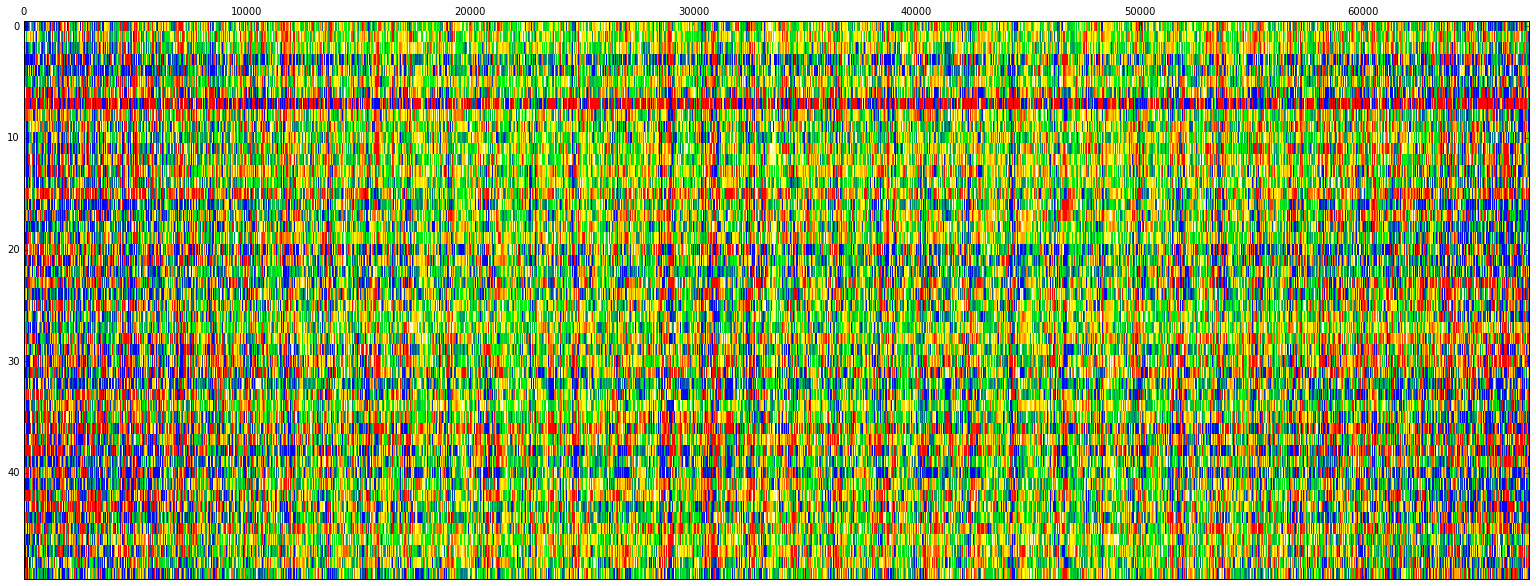

In [43]:
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(dict_resid['resid_{}'.format(trial)][-50:,:],aspect='auto',cmap =a,vmin=-0.001, vmax=0.001)


In [44]:
dict_resid.keys()

dict_keys(['stack_story', 'MZ_df_story', 'DZ_df_story', 'resid_story', 'UnR_df_story', 'Sib_df_story', 'ID_story'])

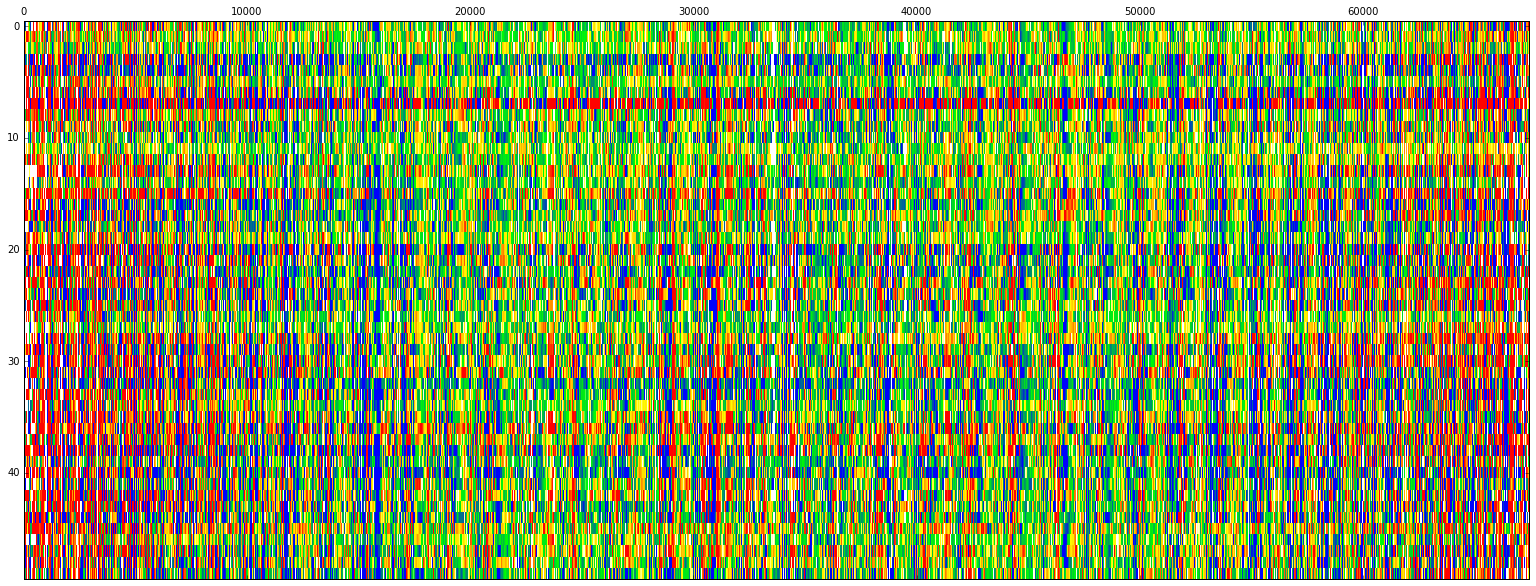

In [45]:
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(dict_resid['stack_{}'.format(trial)][-50:],aspect='auto',cmap =a,vmin=-0.001, vmax=0.001)

#### Fill jobs dictionary

In [46]:
# Generate jobs dictionary 
dict_all = collections.namedtuple('dict_all', ['task','ID','trial','zygos','T1','T2'])
dict_all_list =list()

for trial in list_trial:
    list_dict = [dict_resid['MZ_df_{}'.format(trial)],
                 dict_resid['DZ_df_{}'.format(trial)],
                 dict_resid['Sib_df_{}'.format(trial)],
                 dict_resid['UnR_df_{}'.format(trial)]]
    for dict_ in list_dict:
        zygos = dict_.Zygosity.iloc[0]
        for ID in dict_.Mother_ID.unique():
            pair1 = dict_[dict_.Mother_ID == ID].ID.get_values()[0]
            pair2 = dict_[dict_.Mother_ID == ID].ID.get_values()[1]
            
            mask1 = [idx for idx,sub_id in enumerate(dict_resid['ID_{}'.format(trial)]) if sub_id == pair1]
            mask2 = [idx for idx,sub_id in enumerate(dict_resid['ID_{}'.format(trial)]) if sub_id == pair2]
            
            spm1 = dict_resid['resid_{}'.format(trial)][mask1]
            spm2 = dict_resid['resid_{}'.format(trial)][mask2]

            dict_all_list.append(dict_all(ID=ID,
                                          task = task_mame,
                                          zygos = zygos,
                                          trial = trial,
                                          T1 = spm1,
                                          T2 = spm2))

In [47]:
def run_corr(x):
    results =dict()
        
    for trial in list_trial:
        if x.trial == trial:
            corr  = np.corrcoef(x.T1,x.T2)
            results = {'task':x.task,
                       'zygos':x.zygos,
                       'trial_name' : x.trial,
                       'corr' : corr,
                       'ID' : x.ID
                        }
    return results

In [48]:
# run parralel process
pool = multiprocessing.Pool()
res_= pool.map(run_corr,dict_all_list)

In [53]:
# grab each trial  result
result_final = []
stak_tab_df = pd.DataFrame()

for trial in list_trial:
    result_ = list()
    for zy in ['MZ','NotMZ','NotTwin','UnR']:
        
        # create list of correlation
        corr_list = [x['corr'][0,1] for x in res_ if x['trial_name'] == trial and x['zygos'] == zy ]
        
        # stack it on dataframe
        condit_ = ['{}_{}'.format(trial,zy)] * len(corr_list)
        contras_ = ['{}'.format(trial)] * len(corr_list)
        zygo_ = ['{}'.format(zy)] * len(corr_list)
        stak_tab_df = stak_tab_df.append(pd.DataFrame([np.array(condit_),
                                                       np.array(contras_),
                                                       np.array(zygo_),
                                                       np.abs(corr_list)]).T)
        
        # make another stack on dictionary
        result_dict =  {'task': task_name,
                        'trial_name' : trial,
                        'zygos':zy,
                        'coor_list' : corr_list,
                        'mean_corr' : np.mean(corr_list),
                        'std_corr'  : np.std(corr_list)}
        result_.append(result_dict)
        
    # grab trial corr and std
    tmp_=[[res['task'],res['trial_name'],res['zygos'], res['mean_corr'], res['std_corr']] for res in result_]
    result_final = result_final + tmp_
    
# Save final dataframe 
stak_tab_df.columns=['Task','Condition','Zygosity','Correlation']
stak_tab_df[['Correlation']] = stak_tab_df[['Correlation']].apply(pd.to_numeric) # covert corr to numeric 
stak_tab_df.to_csv(os.path.join(path_spm,'corr_list_{}.csv'.format(task_name)))
stak_tab_df.head(20)

,Task,Condition,Zygosity,Correlation
0,story_MZ,story,MZ,0.221945
1,story_MZ,story,MZ,0.331222
2,story_MZ,story,MZ,0.251545
3,story_MZ,story,MZ,0.390398
4,story_MZ,story,MZ,0.609285
5,story_MZ,story,MZ,0.138593
6,story_MZ,story,MZ,0.292950
7,story_MZ,story,MZ,0.093583
8,story_MZ,story,MZ,0.297541
9,story_MZ,story,MZ,0.165780


In [54]:
corr_df = pd.DataFrame(result_final,columns=['task','trial','zygosity','corr','std'])
corr_df

,task,trial,zygosity,corr,std
0,language,story,MZ,0.244249,0.133160
1,language,story,NotMZ,0.170844,0.150443
2,language,story,NotTwin,0.082555,0.136456
3,language,story,UnR,0.015544,0.137407


In [55]:
#save to csv
corr_df.to_csv(os.path.join(path_spm,'corr_{}.csv'.format(task_mame)))

## Plot figures

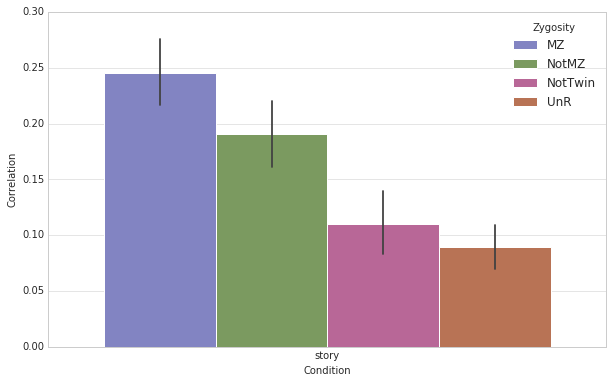

In [56]:
import seaborn as sns

# color for each zygocity type
coll_ = ["#777acd",
         "#7aa456",
         "#c65999",
         "#c96d44"]
coll_list = coll_ * len(list_trial)

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Condition', y='Correlation', palette=coll_list,hue = 'Zygosity',edgecolor='white',data=stak_tab_df)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
plt.savefig(os.path.join(path_spm,'corr_{}.svg'.format(task_name)))

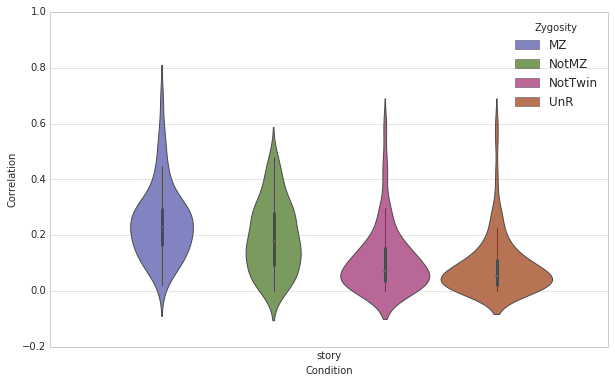

In [57]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.violinplot(x='Condition', y='Correlation', palette=coll_list,edgecolor='white',hue = 'Zygosity',data=stak_tab_df)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
#ax = sns.swarmplot(x="task", y=pd.to_numeric(stak_tab_df['corr']), data=stak_tab_df,color="white", edgecolor="gray")
plt.savefig(os.path.join(path_spm,'corr_violin_{}.svg'.format(task_name)))

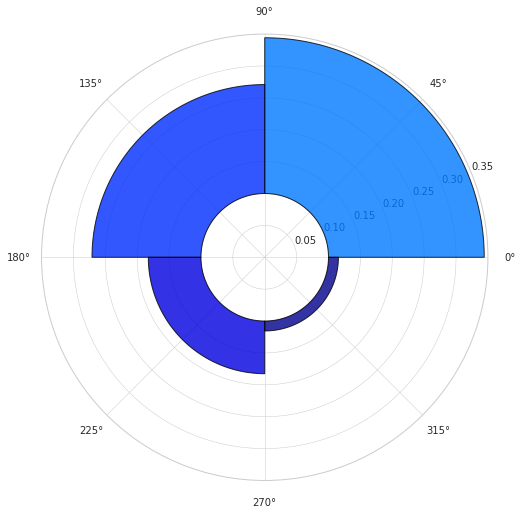

In [61]:
# main fig h2r
N = corr_df['corr'].shape[0]
bottom = 0.1
max_height = 1

theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
#radii = max_height*np.random.rand(N)
radii = corr_df['corr']
width = (2*np.pi) / N
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r))
    bar.set_alpha(0.8)
f.savefig(os.path.join(path_spm,'corr_{}.svg'.format(task_mame)))